In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

In [2]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [ ]:
num_particles = 1000
# num_turns = 6000
num_turns = 1000
plane = 'DPpos'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [13]:
num_particles = 1000000
num_turns = 1_000_000
max_x = 0.042

In [14]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [6]:
env = line.env
# monitor1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, n_repetitions=1, repetition_period=10000, particle_id_range=(num_particles-5, num_particles))
# monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

# env.elements['monitor_qd31110'] = monitor1
# env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
# line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
line.insert([env.place('monitor_start', at=0)])

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [19]:
x_ext = np.linspace(-0.0415, 0.0415, np.sqrt(num_particles).astype(int))
y_ext = np.linspace(-0.0415, 0.0415, np.sqrt(num_particles).astype(int))
X, Y = np.meshgrid(x_ext, y_ext, indexing='xy')
part = line.build_particles(x=X.flatten(), y=Y.flatten())
part.delta = df_to_delta(5000*sweep_per_turn)#tw.particle_on_co.delta
part.zeta = tw.particle_on_co.zeta

In [20]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, time=True, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
part.at_element

array([2547, 2547, 2547, ..., 1608, 1608, 1608], shape=(1000000,))

In [26]:
np.unique(part.at_turn, return_counts=True)

(array([0, 1]), array([912278,  87722]))

In [11]:
df_to_delta(5000*sweep_per_turn) + 0.0415

0.1250668688757655

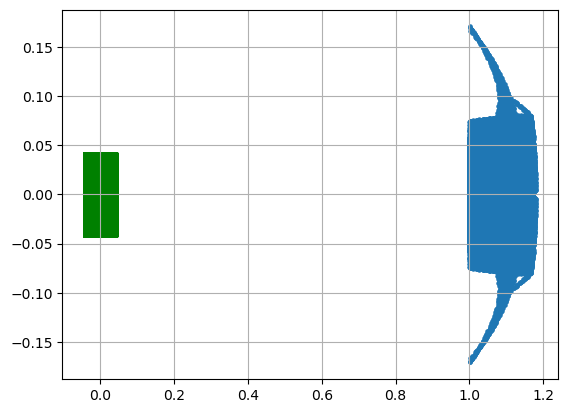

In [23]:
fig, ax = plt.subplots()
ax.scatter(X,Y, s=5, color='green')
ax.scatter(part.x, part.y, s=5)
ax.grid()

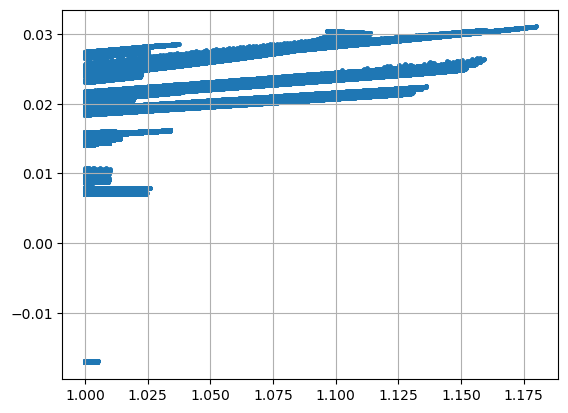

In [24]:
fig, ax = plt.subplots()
# ax.scatter(X,Y, s=5, color='green')
ax.scatter(part.x, part.px, s=5)
ax.grid()